In [ ]:
from zipfile import ZipFile
file_name = "/content/origin_health_role_challenge_dataset.zip"

with ZipFile(file_name , 'r') as zip:
  zip.extractall()
  print('Done')

Done


### Importing Necessary Libraries

In [ ]:
from tensorflow.keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

### **Multclass U-Net Model**

In [ ]:




################################################################
def multi_unet_model(n_classes, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    
    return model

# Setting Up the Directories and Dataset

In [ ]:
SIZE=128
n_classes=6
train_image_dataset=[]
train_mask_dataset=[]
val_image_dataset=[]
val_mask_dataset=[]

In [ ]:
training_image_directory = '/content/interview/train/images'
training_mask_directory = '/content/interview/train/labels'
validation_image_directory = '/content/interview/train/images'
validation_mask_directory = '/content/interview/train/labels'
test_image_directory = '/content/interview/test/images/'

# Preparing the Data For MultiClass Segmentation

**Preparing the training images datset**

In [ ]:
train_images = sorted(os.listdir(training_image_directory))
for i, image_name in enumerate(train_images):    #Remember enumerate method adds a counter and returns the enumerate object
    if (image_name.split('.')[1] == 'png'):
        #print(image_directory+image_name)
        image = cv2.imread(training_image_directory+'/'+image_name, 0)
        # print(image_directory+image_name)
        # image = Image.fromarray(image)
        image = cv2.resize(image,(SIZE, SIZE))
        train_image_dataset.append(image)



**Preparing the Masks Dataset by Resizing it into suitable shape**

In [ ]:
train_masks = sorted(os.listdir(training_mask_directory))
for i, image_name in enumerate(train_masks):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(training_mask_directory+'/' + image_name, 0)
        # image = Image.fromarray(image)
        
        image = cv2.resize(image,(SIZE, SIZE),interpolation = cv2.INTER_NEAREST)
        train_mask_dataset.append(image)

In [ ]:
val_images = sorted(os.listdir(validation_image_directory))
for i, image_name in enumerate(val_images):    #Remember enumerate method adds a counter and returns the enumerate object
    if (image_name.split('.')[1] == 'png'):
        #print(image_directory+image_name)
        image = cv2.imread(validation_image_directory+'/'+image_name, 0)
        # print(image_directory+image_name)
        # image = Image.fromarray(image)
        image = cv2.resize(image,(SIZE, SIZE))
        val_image_dataset.append(image)


In [ ]:
val_masks = sorted(os.listdir(validation_mask_directory))
for i, image_name in enumerate(val_masks):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(validation_mask_directory+'/' + image_name, 0)
        # image = Image.fromarray(image)
        
        image = cv2.resize(image,(SIZE, SIZE),interpolation = cv2.INTER_NEAREST)
        val_mask_dataset.append(image)

In [ ]:
test_image_dataset=[]
test_images = sorted(os.listdir(test_image_directory))
for i, image_name in enumerate(test_images):    #Remember enumerate method adds a counter and returns the enumerate object
    if (image_name.split('.')[1] == 'png'):
        #print(image_directory+image_name)
        image = cv2.imread(test_image_directory+'/'+image_name, 0)
        # print(image_directory+image_name)
        # image = Image.fromarray(image)
        image = cv2.resize(image,(SIZE, SIZE))
        test_image_dataset.append(image)
test_image= np.array(test_image_dataset)

**Finally converting all the image and mask data elements into a Numpy Array**

In [ ]:
train_image = np.array(train_image_dataset)
train_mask = np.array(train_mask_dataset)
val_images = np.array(val_image_dataset)
val_mask = np.array(val_mask_dataset)

**REMEMBER THAT WE NEED TO LABEL ENCODE THE TRAINING MASKS AS IT IS A MULTICLASS CLASSIFICATION AND EACH OF THE MASKS REPRESENTS ONE OF THE 6 CLASSES PRESENT**

In [ ]:

labelencoder = LabelEncoder()
n, h, w = train_mask.shape
train_mask_dataset_reshaped = train_mask.reshape(-1,1)
train_mask_dataset_reshaped_encoded = labelencoder.fit_transform(train_mask_dataset_reshaped)
train_mask_dataset_encoded_original_shape = train_mask_dataset_reshaped_encoded.reshape(n, h, w)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:

labelencoder = LabelEncoder()
n, h, w = val_mask.shape
val_mask_dataset_reshaped = val_mask.reshape(-1,1)
val_mask_dataset_reshaped_encoded = labelencoder.fit_transform(val_mask_dataset_reshaped)
val_mask_dataset_encoded_original_shape = val_mask_dataset_reshaped_encoded.reshape(n, h, w)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


**Finding the number of Unique Masks**

In [ ]:
np.unique(train_mask_dataset_encoded_original_shape)

array([0, 1, 2, 3, 4, 5])

In [ ]:
np.unique(val_mask_dataset_encoded_original_shape)

array([0, 1, 2, 3, 4, 5])

In [ ]:
test_images= normalize(test_image, axis=1)
test_images= np.expand_dims(test_images, axis=3)


In [ ]:
train_images= normalize(train_image, axis=1)
train_images= np.expand_dims(train_images, axis=3)


In [ ]:
val_images= normalize(val_images, axis=1)
val_images= np.expand_dims(val_images, axis=3)


In [ ]:
train_images.shape,val_images.shape

((60, 128, 128, 1), (60, 128, 128, 1))

In [ ]:
train_masks_input = np.expand_dims(train_mask_dataset_encoded_original_shape, axis=3)
val_masks_input = np.expand_dims(val_mask_dataset_encoded_original_shape, axis=3)


In [ ]:
X_train,X_test,y_train,y_test= train_images,val_images,train_masks_input,val_masks_input

In [ ]:
# from sklearn.model_selection import train_test_split
# X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)

In [ ]:
# X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.2, random_state = 0)

In [ ]:
print("Class values in the dataset are ... ", np.unique(y_train)) 

Class values in the dataset are ...  [0 1 2 3 4 5]


In [ ]:
n_classes=6

In [ ]:

train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))


In [ ]:

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))


# Model Creation and Setting Up Metrics

In [ ]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

In [ ]:
def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)


In [ ]:
model = get_model()

**NOTE THAT ACCURACY IS NOT A GOOD METRIC FOR SEGMENTATION PROBLEM, THE BEST ONES ARE THE IOU AND DICE COEFFICIENT. HERE DICE COEFFICIENT HAS BEEN USED**

In [ ]:
from keras import backend as K
def dice_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return dice

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[dice_coef])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 128, 128, 16) 160         input_3[0][0]                    
__________________________________________________________________________________________________
dropout_18 (Dropout)            (None, 128, 128, 16) 0           conv2d_38[0][0]                  
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 128, 128, 16) 2320        dropout_18[0][0]                 
____________________________________________________________________________________________

# Model Training

In [ ]:
history = model.fit(X_train, y_train_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=200, 
                    validation_data=(X_test, y_test_cat), 
                    
                    shuffle=True
                    
                    )

Epoch 1/200
4/4 [==============================] - 4s 415ms/step - loss: 1.8588 - dice_coef: 0.2183 - val_loss: 1.4717 - val_dice_coef: 0.2419
Epoch 2/200
4/4 [==============================] - 0s 63ms/step - loss: 1.4790 - dice_coef: 0.2577 - val_loss: 1.6427 - val_dice_coef: 0.1953
Epoch 3/200
4/4 [==============================] - 0s 60ms/step - loss: 1.5981 - dice_coef: 0.2060 - val_loss: 1.5472 - val_dice_coef: 0.2173
Epoch 4/200
4/4 [==============================] - 0s 61ms/step - loss: 1.4689 - dice_coef: 0.2410 - val_loss: 1.2946 - val_dice_coef: 0.2966
Epoch 5/200
4/4 [==============================] - 0s 63ms/step - loss: 1.2144 - dice_coef: 0.3816 - val_loss: 1.1296 - val_dice_coef: 0.3831
Epoch 6/200
4/4 [==============================] - 0s 60ms/step - loss: 1.1306 - dice_coef: 0.4123 - val_loss: 1.1253 - val_dice_coef: 0.3738
Epoch 7/200
4/4 [==============================] - 0s 62ms/step - loss: 1.1007 - dice_coef: 0.4126 - val_loss: 1.0385 - val_dice_coef: 0.4253
Epoch

In [ ]:
model.save('UNet_Final_Model.hdf5')
model.save('UNet_Final_Model.h5')

############################################################
#Evaluate the model
	# evaluate model
_, acc = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")


2/2 [==============================] - 0s 38ms/step - loss: 0.0451 - dice_coef: 0.9713
Accuracy is =  97.13170528411865 %


# Generating Model Performance Report

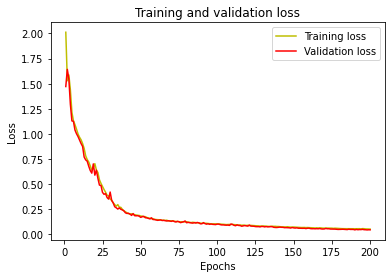

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

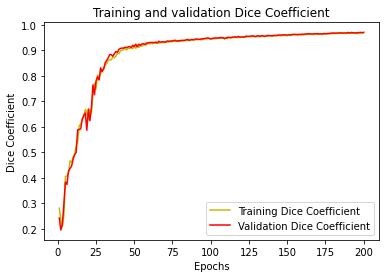

In [ ]:
acc = history.history['dice_coef']
val_acc = history.history['val_dice_coef']

plt.plot(epochs, acc, 'y', label='Training Dice Coefficient')
plt.plot(epochs, val_acc, 'r', label='Validation Dice Coefficient')
plt.title('Training and validation Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()

In [ ]:
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)


**Finding out the mean IOU as it also gives a measure on the model performance**

In [ ]:

from keras.metrics import MeanIoU
n_classes = 6
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.8080509


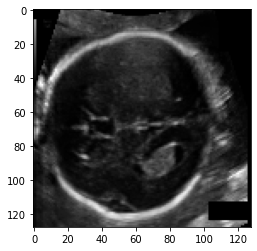

In [ ]:
plt.imshow(train_images[0, :,:,0], cmap='gray')
# plt.imshow(masks[0], cmap='gray')

# Visualizing the Predictions Performed

## On Validation Dataset

In [ ]:
import random
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

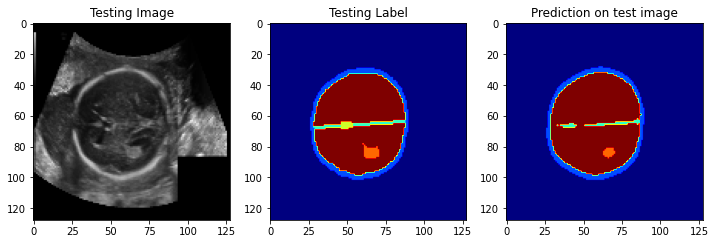

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()

## On Test Image Dataset

In [ ]:
X_test= test_images

In [ ]:
import random
# test_img_number = random.randint(0, len(X_test)-1)
test_img_number =2
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

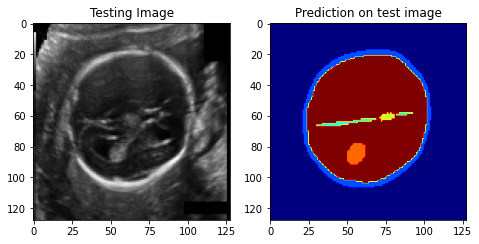

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
# plt.subplot(232)
# plt.title('Testing Label')
# plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(232)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()


# Generating the Output Files

In [ ]:
# test_img_number = random.randint(0, len(X_test))
count = len(X_test)
test_labels = {}
for test_img_number in range(0,count):
  test_img = X_test[test_img_number]
  # ground_truth=y_test[test_img_number]
  test_img_norm=test_img[:,:,0][:,:,None]
  test_img_input=np.expand_dims(test_img_norm, 0)
  prediction = (model.predict(test_img_input))
  predicted_img=np.argmax(prediction, axis=3)[0,:,:]
  test_labels[test_img_number]= predicted_img




In [ ]:
with open("UNetPredictions.txt", 'w') as f: 
    for key, value in test_labels.items(): 
        f.write('%s:%s\n' % (key, value))